# Worksheet 10 - Clustering

### Lecture and Tutorial Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:

* Describe a case where clustering would be an appropriate tool, and what insight it would bring from the data.
* Explain the k-means clustering algorithm.
* Interpret the output of a k-means cluster analysis.
* Perform k-means clustering in R using k-means
* Visualize the output of k-means clustering in R using a coloured scatter plot
* Identify when it is necessary to scale variables before clustering and do this using R
* Use the elbow method to choose the number of clusters for k-means
* Describe advantages, limitations and assumptions of the k-means clustering algorithm.

In [2]:
### Run this cell before continuing.
library(tidyverse)
library(forcats)
library(repr)
library(broom)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

**Question 0.0** Multiple Choice:
<br> {points: 1}

In which of the following scenarios would clustering methods likely be appropriate?

A. Identifying sub-groups of houses according to their house type, value, and geographical location

B. Predicting whether a given user will click on an ad on a website

C. Segmenting customers based on their preferences to target advertising

D. Both A. and B.

E. Both A. and C. 

*Assign your answer to an object called `answer0.0`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [5]:
answer0.0 <- "E"

In [6]:
test_0.0()

[1] "Success!"


**Question 0.1** Multiple Choice:
<br> {points: 1}

Which step in the description of the k-means algorithm below is *incorrect*?

0. Choose the number of clusters

1. Randomly assign each of the points to one of the clusters

2. Calculate the position for the cluster centre (centroid) for each of the clusters (this is the middle of the points in the cluster, as measured by straight-line distance)

3. Re-assign each of the points to the cluster whose centroid is furthest from that point

4. Repeat steps 1 - 3 until the cluster centroids don't change at all

*Assign your answer to an object called `answer0.1`. Your answer should be a single numerical character surrounded by quotes.*

In [8]:
answer0.1 <- "3"

In [9]:
test_0.1()

[1] "Success!"


## Hoppy Craft Beer

Craft beer is a strong market in Canada and the US, and is expanding to other countries as well. If you wanted to get into the craft beer brewing market, you might want to better understand the product landscape. One popular craft beer product is hopped craft beer. Breweries create/label many different kinds of hopped craft beer, but how many different kinds of hopped craft beer are there really when you look at the chemical properties instead of the human labels? 

We will start to look at the question by looking at a [craft beer data set from Kaggle](https://www.kaggle.com/nickhould/craft-cans#beers.csv). In this data set, we will use the alcoholic content by volume  (`abv` column) and the International bittering units (`ibu` column) as variables to try to cluster the beers. The `abv` variable has values 0 (indicating no alcohol) up to 1 (pure alcohol) and the `ibu` variable quantifies the bitterness of the beer (higher values indicate higher bitterness).

**Question 1.0** 
<br> {points: 1}

Read in the `beers.csv` data using `read_csv()` and assign it to an object called `beer`. The data is located within the `worksheet_10/data/` folder. 

*Assign your dataframe answer to an object called `beer`.*

In [17]:
beer <- read_csv("data/beers.csv")
beer

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  X1 = col_double(),
  abv = col_double(),
  ibu = col_double(),
  id = col_double(),
  name = col_character(),
  style = col_character(),
  brewery_id = col_double(),
  ounces = col_double()
)



X1,abv,ibu,id,name,style,brewery_id,ounces
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
0,0.050,NA,1436,Pub Beer,American Pale Lager,408,12
1,0.066,NA,2265,Devil's Cup,American Pale Ale (APA),177,12
2,0.071,NA,2264,Rise of the Phoenix,American IPA,177,12
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2407,0.055,NA,620,B3K Black Lager,Schwarzbier,424,12
2408,0.055,40,145,Silverback Pale Ale,American Pale Ale (APA),424,12
2409,0.052,NA,84,Rail Yard Ale (2009),American Amber / Red Ale,424,12


In [11]:
test_1.0()

[1] "Success!"


**Question 1.1**
<br> {points: 1}

Let's start by visualizing the variables we are going to use in our cluster analysis as a scatter plot. Put `ibu` on the horizontal axis, and `abv` on the vertical axis. Name the plot object `beer_plot`. 

*Remember to follow the best visualization practices, including adding human-readable labels to your plot.*

Warning message:
“Removed 1005 rows containing missing values (geom_point).”


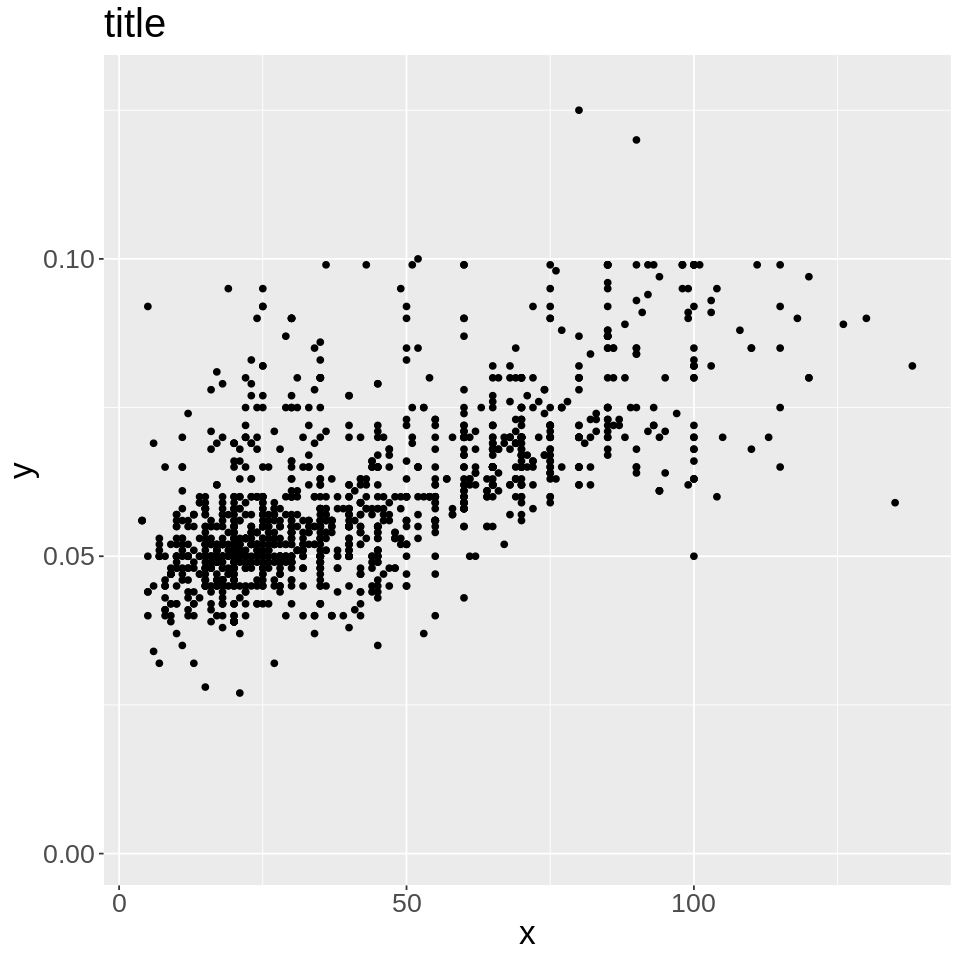

In [13]:
options(repr.plot.height = 8, repr.plot.width = 8)
beer_plot <- ggplot(beer, aes(x = ibu, y = abv)) +
    geom_point() +
    labs(x = "x", y = "y", title = "title") +
    theme(text = element_text(size = 20))
beer_plot

In [14]:
test_1.1()

[1] "Success!"


**Question 1.2**
<br> {points: 1}

We need to clean this data a bit. Specifically, we need to remove the rows where `ibu` is `NA`, and select only the columns we are interested in clustering, which are `ibu` and `abv`. 

*Assign your answer to an object named `clean_beer`.*

In [30]:
clean_beer <- beer %>%
    filter(!is.na(ibu)) %>%
    select(ibu, abv)

In [31]:
test_1.2()

[1] "Success!"


**Question 1.3.1** Multiple Choice:
<br>{points: 1}

Why do we need to scale the variables when using k-means clustering?

A. k-means uses the Euclidean distance to compute how similar data points are to each cluster center

B. k-means is an iterative algorithm

C. Some variables might be more important for prediction than others

D. To make sure their mean is 0

*Assign your answer to an object named `answer1.3.1`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [34]:
answer1.3.1 <- "A"

In [35]:
test_1.3.1()

[1] "Success!"


**Question 1.3.2**
<br> {points: 1}

Let's do that scaling now. Recall that we used a `recipe` for scaling when doing classification and regression. This is because we needed to be able to split train and test data, compute a standardization on *just* training data, and apply the standardization to *both* train and test data.

But in clustering, there is no train/test split. So let's use the much simpler `scale` function in R. `scale` takes in a column of a dataframe and outputs the standardized version of it. We can therefore apply `scale` to all variables in the cleaned data frame using `mutate` + `across`. You can revisit the section: [Data pre-processing for K-means](https://datasciencebook.ca/clustering.html#data-pre-processing-for-k-means) for further discussion. 

*Note: you could still use a recipe to do this, using `prep`/`bake` appropriately. But `scale` is much simpler.*

*Assign your answer to an object named `scaled_beer`. Use the scaffolding provided.*

In [36]:
# ... <- ... %>% 
#    mutate(across(..., ...))

scaled_beer <- clean_beer %>%
    mutate(across(everything(), scale))

In [37]:
test_1.3.2()

[1] "Success!"


**Question 1.4**
<br> {points: 1}

From our exploratory data visualization, 2 seems like a reasonable number of clusters. Use the `kmeans` function with `centers = 2` to perform clustering with this choice of $k$. 

*Assign your model to an object named `beer_cluster_k2`. Note that since k-means uses a random initialization, we need to set the seed again; don't change the value!*

In [39]:
# DON'T CHANGE THE SEED VALUE!
set.seed(1234)

# ... <- kmeans(..., centers = 2)

beer_cluster_k2 <- kmeans(scaled_beer, centers = 2)

In [40]:
test_1.4()

[1] "Success!"


**Question 1.5**
<br> {points: 1}

Use the `augment` function from the `broom` package to get the cluster assignment for each point in the `scaled_beer` data frame. 

*Assign your answer to an object named `tidy_beer_cluster_k2`.* 

In [44]:
# ... <- augment(..., ...)
library(broom)

tidy_beer_cluster_k2 <- augment(beer_cluster_k2, scaled_beer)
tidy_beer_cluster_k2

ibu,abv,.cluster
"<dbl[,1]>","<dbl[,1]>",<fct>
0.66605490,0.08000109,2
1.89900237,2.87899086,2
0.08811077,1.40583835,2
⋮,⋮,⋮
0.28075881,0.006343468,1
0.08811077,0.521946846,2
-0.10453727,-0.361944659,1


In [43]:
test_1.5()

[1] "Success!"


**Question 1.6**
<br> {points: 1}

Create a scatter plot of `abv` on the y-axis versus `ibu` on the x-axis (using the data in `tidy_beer_cluster_k2`) where the points are labelled by their cluster assignment. Name the plot object `tidy_beer_cluster_k2_plot`.

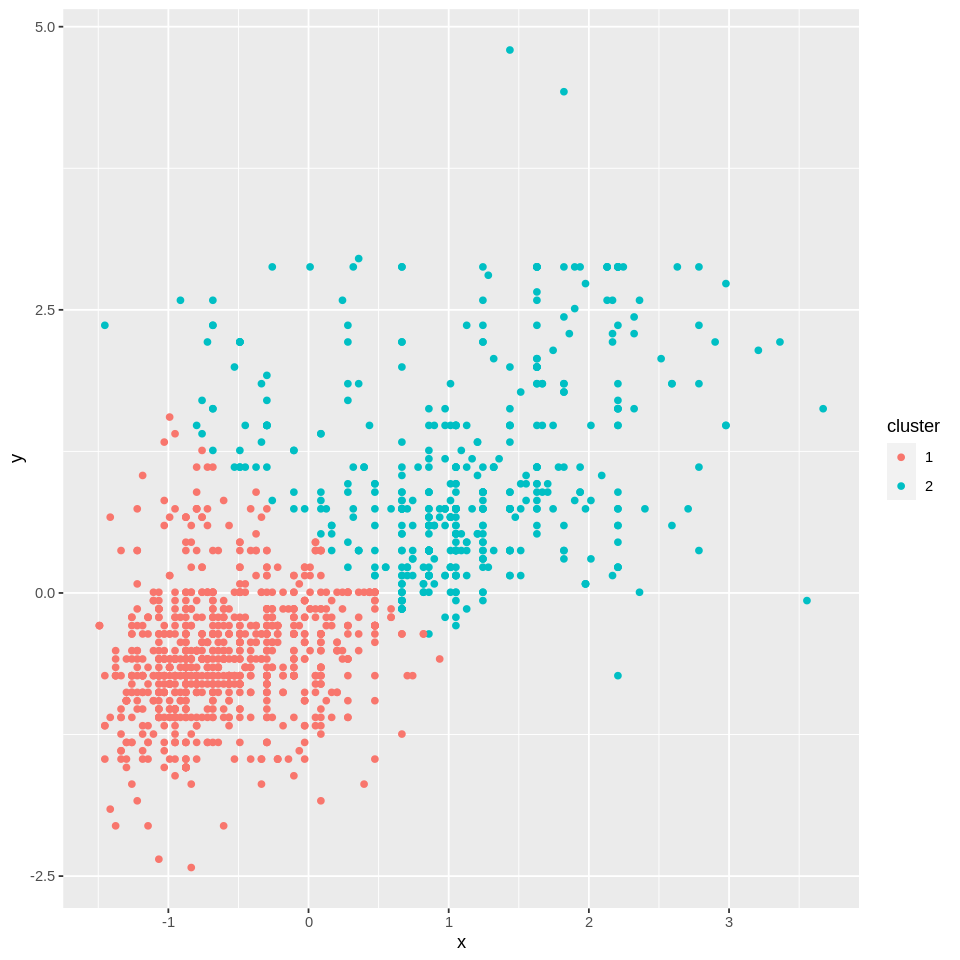

In [55]:
tidy_beer_cluster_k2_plot <- ggplot(tidy_beer_cluster_k2, aes(x = ibu, y = abv)) +
    geom_point(aes(color = .cluster)) +
    labs(x = "x", y = "y", color = "cluster")
tidy_beer_cluster_k2_plot

In [56]:
test_1.6()

[1] "Success!"


**Question 1.7.1** Multiple Choice:
<br> {points: 1}

We do not know, however, that two clusters ($k$ = 2) is the best choice for this data set. What can we do to choose the best K?

A. Perform *cross-validation* for a variety of possible $k$'s. Choose the one where within-cluster sum of squares distance starts to *decrease less*.

B. Perform *cross-validation* for a variety of possible $k$'s. Choose the one where the within-cluster sum of squares distance starts to *decrease more*. 

C. Perform *clustering* for a variety of possible $k$'s. Choose the one where within-cluster sum of squares distance starts to *decrease less*.

D. Perform *clustering* for a variety of possible $k$'s. Choose the one where the within-cluster sum of squares distance starts to *decrease more*. 

*Assign your answer to an object called `answer1.7.1`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [57]:
answer1.7.1 <- "C"

In [58]:
test_1.7.1()

[1] "Success!"


**Question 1.7.2**
<br> {points: 1}

Use the `glance` function from the `broom` library to get the model-level statistics for the clustering we just performed, including total within-cluster sum of squares. 

*Assign your answer to an object named `beer_cluster_k2_model_stats`.*

In [60]:
beer_cluster_k2_model_stats <- glance(beer_cluster_k2)

In [61]:
test_1.7.2()

[1] "Success!"


**Question 1.8**
<br> {points: 1}

Let's now choose the best K for this clustering problem. To do this we need to create a tibble with a column named `k`, where $k$ has values 1 to 10. 

*Assign your answer to an object named `beer_ks`.*

In [62]:
beer_ks <- tibble(k = 1:10)

In [63]:
test_1.8()

[1] "Success!"


**Question 1.9**
<br> {points: 1}

Next, we use `rowwise()` to arrange the k-values in `beer_ks` into rows. Then we use `mutate` to create a new column named `models` in `beer_ks` where we  apply the `kmeans` function to our `scaled_beer` data set for each of the $k$'s. 

> You might want to refer back to the section of the textbook that explains before completing this question: [K-means in R](https://ubc-dsci.github.io/introduction-to-datascience/clustering.html#k-means-in-r)

This will give us a data frame with two columns, the first being `k`, which holds the values of the $k$'s. The second will be `models`, which holds the $k$-means model fits for each of the $k$'s. 

> This second column is a new type of column, that we have not yet encountered in this course. It is called a list column. It can contain more complex objects, like models and even data frames (as we will see in a later question). In Jupyter it is easier to preview and understand this more complex data frame using the `print` function as opposed to calling the data frame itself as we usually do. This is a current limitation of Jupyter's rendering of R's output and will hopefully be fixed in the future.  

*Assign your answer to an object named `beer_clustering`.*

In [72]:
set.seed(1234) # DO NOT REMOVE
# ... <- ... %>%
    # rowwise() %>%
    # mutate(models = list(kmeans(..., ...)))

beer_clustering <- beer_ks %>%
    rowwise() %>%
    mutate(models = list(kmeans(scaled_beer, k)))


In [65]:
test_1.9()

[1] "Success!"


**Question 2.0**
<br> {points: 1}

Next we use `mutate` again to create a new column called `model_statistics` where apply the `glance` function to each of our models (in the `models` column) to get the model-level statistics (this is where we can get the value for total within sum of squares that we use to choose K). 

> Here, because we are interating over the first argument to the `glance` function (which is the `models` column). 

*Assign your answer to an object named `beer_model_stats`.*

In [70]:
# ... <- ... %>% 
    # mutate(... = list(models, ...))

beer_model_stats <- beer_clustering %>%
    mutate(model_statistics = list(glance(models)))


In [68]:
test_2.0()

[1] "Success!"


> Here when we create our third column, called `model_statistics`, we can see it is another list column! This time it contains data frames instead of models! Run the cell below to see how you can look at the data frame that is stored as the first element of the `model_statistics` column (model where we used $k$ = 1):

In [73]:
beer_model_stats %>% 
    slice(1) %>% 
    pull(model_statistics)

totss,tot.withinss,betweenss,iter
<dbl>,<dbl>,<dbl>,<int>
2808,2808,-2.273737e-12,1
totss,tot.withinss,betweenss,iter
<dbl>,<dbl>,<dbl>,<int>
2808,1110.102,1697.898,1
totss,tot.withinss,betweenss,iter
<dbl>,<dbl>,<dbl>,<int>
2808,803.3023,2004.698,3
totss,tot.withinss,betweenss,iter
<dbl>,<dbl>,<dbl>,<int>


**Question 2.1**
<br> {points: 1}

Now we use the `unnest` function to expand the data frames in the `model_statistics` column so that we can access the values for total within sum of squares as a column. 

*Assign your answer to an object named `beer_clustering_unnested`.*

In [74]:
# ... <- ... %>% unnest(model_statistics)

beer_clustering_unnested <- beer_model_stats %>%
    unnest(model_statistics)

print(beer_clustering_unnested)

# A tibble: 10 x 6
       k models   totss tot.withinss betweenss  iter
   <int> <list>   <dbl>        <dbl>     <dbl> <int>
 1     1 <kmeans> 2808.        2808. -2.27e-12     1
 2     2 <kmeans> 2808.        1110.  1.70e+ 3     1
 3     3 <kmeans> 2808.         803.  2.00e+ 3     3
 4     4 <kmeans> 2808.         624.  2.18e+ 3     3
 5     5 <kmeans> 2808.         567.  2.24e+ 3     3
 6     6 <kmeans> 2808.         417.  2.39e+ 3     6
 7     7 <kmeans> 2808.         361.  2.45e+ 3     6
 8     8 <kmeans> 2808.         318.  2.49e+ 3     5
 9     9 <kmeans> 2808.         294.  2.51e+ 3     4
10    10 <kmeans> 2808.         264.  2.54e+ 3     6


In [75]:
test_2.1()

[1] "Success!"


**Question 2.2**
<br> {points: 1}

We now have the the values for total within-cluster sum of squares for each model in a column (`tot.withinss`). Let's use it to create a line plot with points of total within-cluster sum of squares versus k, so that we can choose the best number of clusters to use. 

*Assign your plot to an object called `choose_beer_k`. Total within-cluster sum of squares should be on the y-axis and K should be on the x-axis. Remember to follow the best visualization practices, including adding human-readable labels to your plot.*

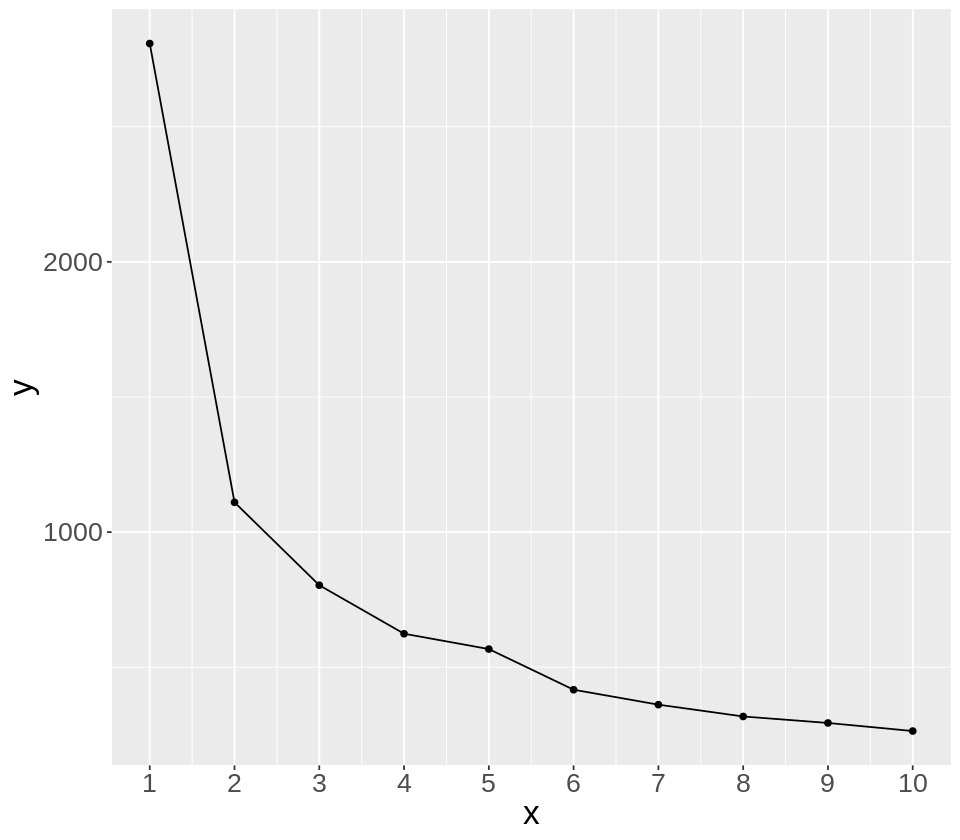

In [78]:
options(repr.plot.width = 8, repr.plot.height = 7)

choose_beer_k <- ggplot(beer_clustering_unnested, aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "x", y = "y") +
    scale_x_continuous(breaks = 1:10) +
    theme(text = element_text(size = 20))
choose_beer_k


In [79]:
test_2.2()

[1] "Success!"


**Question 2.3**
<br> {points: 1}

From the plot above, which $k$ should we choose? 

*Assign your answer to an object called `answer2.3`. Make sure your answer is a single numerical character surrounded by quotation marks.*

In [81]:
answer2.3 <- "2"

In [82]:
test_2.3()

[1] "Success!"


**Question 2.4**
<br> {points: 1}

Why did we choose the $k$ we chose above?

A. It had the greatest total within-cluster sum of squares

B. It had the smallest total within-cluster sum of squares

C. Increasing $k$ further than this only decreased the total within-cluster sum of squares a small amount

D. Increasing k further than this only increased the total within-cluster sum of squares a small amount

*Assign your answer to an object called `answer2.4`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [83]:
answer2.4 <- "C"

In [84]:
test_2.4()

[1] "Success!"


**Question 2.5** Multiple Choice:
<br> {points: 1}

What can we conclude from our analysis? How many different types of hoppy craft beer are there in this data set using the two variables we have? 


A. 1 or 2

B. 2 or 3

C. 4 or 5

D. 5 or 6

*Assign your answer to an object called `answer2.5`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [87]:
answer2.5 <- "B"

In [88]:
test_2.5()

[1] "Success!"


**Question 2.6** True or false:
<br> {points: 1}

Our analysis might change if we added additional variables, true or false?

*Assign your answer to an object called `answer2.6`. Make sure your answer is written in lowercase and is surrounded by quotation marks (e.g. `"true"` or `"false"`).* 

In [90]:
answer2.6 <- "true"

In [91]:
test_2.6()

[1] "Success!"


In [ ]:
source("cleanup.R")